In [ ]:
pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107730 sha256=daacb800d68b3a51ac8f03d1b54eedcb8182ce0f457e66f5e8b202901c489306
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [ ]:
!pip install tldextract -q

In [ ]:
import pandas as pd
import numpy as np
import random
import sys
import os
import tldextract
import warnings
import regex as re
import eli5
from typing import *

from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from nltk.tokenize import RegexpTokenizer

warnings.filterwarnings("ignore")

In [ ]:
url_data = pd.read_csv('phishing_site_urls.csv')
url_data.head()

,URL,Label
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad
3,mail.printakid.com/www.online.americanexpress....,bad
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad


In [ ]:
url_data = url_data.rename(columns={"URL": "url", "Label": "label"})

In [ ]:
def parse_url(url: str) -> Optional[Dict[str, str]]:
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "scheme": None, # not established a value for this
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

In [ ]:
url_data["parsed_url"] = url_data.url.apply(parse_url)
url_data

,url,label,parsed_url
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,"{'scheme': None, 'netloc': 'nobell.it', 'path'..."
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,"{'scheme': None, 'netloc': 'www.dghjdgf.com', ..."
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,"{'scheme': None, 'netloc': 'serviciosbys.com',..."
3,mail.printakid.com/www.online.americanexpress....,bad,"{'scheme': None, 'netloc': 'mail.printakid.com..."
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,"{'scheme': None, 'netloc': 'thewhiskeydregs.co..."
...,...,...,...
549341,23.227.196.215/,bad,"{'scheme': None, 'netloc': '23.227.196.215', '..."
549342,apple-checker.org/,bad,"{'scheme': None, 'netloc': 'apple-checker.org'..."
549343,apple-iclods.org/,bad,"{'scheme': None, 'netloc': 'apple-iclods.org',..."
549344,apple-uptoday.org/,bad,"{'scheme': None, 'netloc': 'apple-uptoday.org'..."


In [ ]:
url_data = pd.concat([
    url_data.drop(['parsed_url'], axis=1),
    url_data['parsed_url'].apply(pd.Series)
], axis=1)
url_data

,url,label,scheme,netloc,path,params,query,fragment
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,None,nobell.it,/70ffb52d079109dca5664cce6f317373782/login.Sky...,,cmd=_profile-ach&outdated_page_tmpl=p/gen/fail...,
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,None,www.dghjdgf.com,/paypal.co.uk/cycgi-bin/webscrcmd=_home-custom...,,,
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,None,serviciosbys.com,/paypal.cgi.bin.get-into.herf.secure.dispatch3...,,,
3,mail.printakid.com/www.online.americanexpress....,bad,None,mail.printakid.com,/www.online.americanexpress.com/index.html,,,
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,None,thewhiskeydregs.com,/wp-content/themes/widescreen/includes/temp/pr...,,84784787824HDJNDJDSJSHD//2724782784/,
...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,None,23.227.196.215,/,,,
549342,apple-checker.org/,bad,None,apple-checker.org,/,,,
549343,apple-iclods.org/,bad,None,apple-iclods.org,/,,,
549344,apple-uptoday.org/,bad,None,apple-uptoday.org,/,,,


In [ ]:
url_data = url_data[~url_data.netloc.isnull()]
url_data

,url,label,scheme,netloc,path,params,query,fragment
0,nobell.it/70ffb52d079109dca5664cce6f317373782/...,bad,None,nobell.it,/70ffb52d079109dca5664cce6f317373782/login.Sky...,,cmd=_profile-ach&outdated_page_tmpl=p/gen/fail...,
1,www.dghjdgf.com/paypal.co.uk/cycgi-bin/webscrc...,bad,None,www.dghjdgf.com,/paypal.co.uk/cycgi-bin/webscrcmd=_home-custom...,,,
2,serviciosbys.com/paypal.cgi.bin.get-into.herf....,bad,None,serviciosbys.com,/paypal.cgi.bin.get-into.herf.secure.dispatch3...,,,
3,mail.printakid.com/www.online.americanexpress....,bad,None,mail.printakid.com,/www.online.americanexpress.com/index.html,,,
4,thewhiskeydregs.com/wp-content/themes/widescre...,bad,None,thewhiskeydregs.com,/wp-content/themes/widescreen/includes/temp/pr...,,84784787824HDJNDJDSJSHD//2724782784/,
...,...,...,...,...,...,...,...,...
549341,23.227.196.215/,bad,None,23.227.196.215,/,,,
549342,apple-checker.org/,bad,None,apple-checker.org,/,,,
549343,apple-iclods.org/,bad,None,apple-iclods.org,/,,,
549344,apple-uptoday.org/,bad,None,apple-uptoday.org,/,,,


In [ ]:
url_data["length"] = url_data.url.str.len()

In [ ]:
url_data["tld"] = url_data.netloc.apply(lambda nl: tldextract.extract(nl).suffix)
url_data['tld'] = url_data['tld'].replace('','None')

In [ ]:
url_data["is_ip"] = url_data.netloc.str.fullmatch(r"\d+\.\d+\.\d+\.\d+")

In [ ]:
url_data['domain_hyphens'] = url_data.netloc.str.count('-')
url_data['domain_underscores'] = url_data.netloc.str.count('_')
url_data['path_hyphens'] = url_data.path.str.count('-')
url_data['path_underscores'] = url_data.path.str.count('_')
url_data['slashes'] = url_data.path.str.count('/')

In [ ]:
url_data['full_stops'] = url_data.path.str.count('.')

In [ ]:
def get_num_subdomains(netloc: str) -> int:
    subdomain = tldextract.extract(netloc).subdomain
    if subdomain == "":
        return 0
    return subdomain.count('.') + 1

url_data['num_subdomains'] = url_data['netloc'].apply(lambda net: get_num_subdomains(net))

In [ ]:
tokenizer = RegexpTokenizer(r'[A-Za-z]+')
def tokenize_domain(netloc: str) -> str:
    split_domain = tldextract.extract(netloc)
    no_tld = str(split_domain.subdomain +'.'+ split_domain.domain)
    return " ".join(map(str,tokenizer.tokenize(no_tld)))

url_data['domain_tokens'] = url_data['netloc'].apply(lambda net: tokenize_domain(net))

In [ ]:
url_data['path_tokens'] = url_data['path'].apply(lambda path: " ".join(map(str,tokenizer.tokenize(path))))

In [ ]:
url_data_y = url_data['label']
url_data.drop('label', axis=1, inplace=True)
url_data.drop('url', axis=1, inplace=True)
url_data.drop('scheme', axis=1, inplace=True)
url_data.drop('netloc', axis=1, inplace=True)
url_data.drop('path', axis=1, inplace=True)
url_data.drop('params', axis=1, inplace=True)
url_data.drop('query', axis=1, inplace=True)
url_data.drop('fragment', axis=1, inplace=True)
url_data

,length,tld,is_ip,domain_hyphens,domain_underscores,path_hyphens,path_underscores,slashes,full_stops,num_subdomains,domain_tokens,path_tokens
0,225,it,False,0,0,1,0,8,125,0,nobell,ffb d dca cce f login SkyPe com en cgi bin ver...
1,81,com,False,0,0,2,1,4,66,1,www dghjdgf,paypal co uk cycgi bin webscrcmd home customer...
2,177,com,False,0,0,1,0,11,161,0,serviciosbys,paypal cgi bin get into herf secure dispatch r...
3,60,com,False,0,0,0,0,2,42,1,mail printakid,www online americanexpress com index html
4,116,com,False,0,0,1,0,7,60,0,thewhiskeydregs,wp content themes widescreen includes temp pro...
...,...,...,...,...,...,...,...,...,...,...,...,...
549341,15,None,True,0,0,0,0,1,1,0,,
549342,18,org,False,1,0,0,0,1,1,0,apple checker,
549343,17,org,False,1,0,0,0,1,1,0,apple iclods,
549344,18,org,False,1,0,0,0,1,1,0,apple uptoday,


In [ ]:
class Converter(BaseEstimator, TransformerMixin):
    def fit(self, x, y=None):
        return self

    def transform(self, data_frame):
        return data_frame.values.ravel()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(url_data, url_data_y, test_size=0.2)

In [ ]:
numeric_features = ['length', 'domain_hyphens', 'domain_underscores', 'path_hyphens', 'path_underscores', 'slashes', 'full_stops', 'num_subdomains']
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())])

In [ ]:
categorical_features = ['tld', 'is_ip']
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [ ]:
vectorizer_features = ['domain_tokens','path_tokens']
vectorizer_transformer = Pipeline(steps=[
    ('con', Converter()),
    ('tf', TfidfVectorizer())])

In [ ]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('domvec', vectorizer_transformer, ['domain_tokens']),
        ('pathvec', vectorizer_transformer, ['path_tokens'])
    ])

nb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', MultinomialNB())])

In [ ]:
nb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['length', 'domain_hyphens',
                                                   'domain_underscores',
                                                   'path_hyphens',
                                                   'path_underscores',
                                                   'slashes', 'full_stops',
                                                   'num_subdomains']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['tld', 'is_ip']),
                                                 ('domvec',
                                                  Pipeline(steps=[('con',
                                                                   Converter()),
                                                                  ('tf',
                                                                   TfidfVectorizer())]),
                                                  ['domain_tokens']),
                                                 ('pathvec',
                                                  Pipeline(steps=[('con',
                                                                   Converter()),
                                                                  ('tf',
                                                                   TfidfVectorizer())]),
                                                  ['path_tokens'])])),
                ('classifier', MultinomialNB())])

In [ ]:
def results(name: str, model: BaseEstimator) -> None:
    preds = model.predict(X_test)

    print(name + " score: %.3f" % model.score(X_test, y_test))
    print(classification_report(y_test, preds))
    labels = ['Good', 'Bad']

    conf_matrix = confusion_matrix(y_test, preds)

    font = {'family' : 'normal',
            'size'   : 14}

    plt.rc('font', **font)
    plt.figure(figsize= (10,6))
    sns.heatmap(conf_matrix, xticklabels=labels, yticklabels=labels, annot=True, fmt="d", cmap='Blues')
    plt.title("Confusion Matrix for " + name)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')

Naive Bayes score: 0.972
              precision    recall  f1-score   support

         bad       0.96      0.94      0.95     31415
        good       0.98      0.99      0.98     78452

    accuracy                           0.97    109867
   macro avg       0.97      0.96      0.97    109867
weighted avg       0.97      0.97      0.97    109867



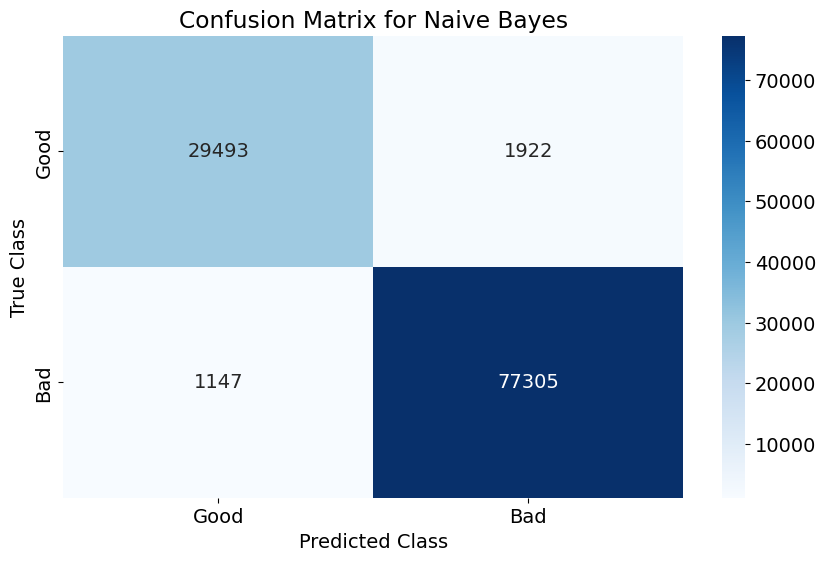

In [ ]:
results("Naive Bayes" , nb_clf)

In [ ]:
import joblib

# Save the model as a pickle file
joblib.dump(nb_clf, 'naive_bayes_classifier.pkl')


['naive_bayes_classifier.pkl']

In [ ]:
def parse_url(url: str) -> Optional[Dict[str, str]]:
    try:
        no_scheme = not url.startswith('https://') and not url.startswith('http://')
        if no_scheme:
            parsed_url = urlparse(f"http://{url}")
            return {
                "url": url,
                "scheme": None, # not established a value for this
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
        else:
            parsed_url = urlparse(url)
            return {
                "url": url,
                "scheme": parsed_url.scheme,
                "netloc": parsed_url.netloc,
                "path": parsed_url.path,
                "params": parsed_url.params,
                "query": parsed_url.query,
                "fragment": parsed_url.fragment,
            }
    except:
        return None

In [ ]:
def predict_url(model, url: str) -> Tuple[str, float]:
    # Parse the URL and extract features
    parsed_url = parse_url(url)
    data = pd.DataFrame.from_records([parsed_url])
    data["length"] = data.url.str.len()
    data["tld"] = data.netloc.apply(lambda nl: tldextract.extract(nl).suffix)
    data['tld'] = data['tld'].replace('','None')
    data["is_ip"] = data.netloc.str.fullmatch(r"\d+\.\d+\.\d+\.\d+")
    data['domain_hyphens'] = data.netloc.str.count('-')
    data['domain_underscores'] = data.netloc.str.count('_')
    data['path_hyphens'] = data.path.str.count('-')
    data['path_underscores'] = data.path.str.count('_')
    data['slashes'] = data.path.str.count('/')
    data['full_stops'] = data.path.str.count('.')
    data['num_subdomains'] = data['netloc'].apply(lambda net: get_num_subdomains(net))
    data['domain_tokens'] = data['netloc'].apply(lambda net: tokenize_domain(net))
    data['path_tokens'] = data['path'].apply(lambda path: " ".join(map(str,tokenizer.tokenize(path))))
    data.drop(['url', 'scheme', 'netloc', 'path', 'params', 'query', 'fragment'], axis=1, inplace=True)

    # Make prediction
    pred = model.predict(data)
    pred_proba = model.predict_proba(data)

    # Return prediction and its confidence level
    return pred[0], max(pred_proba[0])


url = "spenk.co.uk/bad_scampage_script"
prediction, confidence = predict_url(nb_clf, url)
print(f"Prediction: {prediction}, Confidence: {confidence}")

Prediction: bad, Confidence: 0.9329789608045447


In [ ]:
import joblib

# Save the model as a pickle file
joblib.dump(nb_clf, 'naive_bayes_classifier.pkl')

['naive_bayes_classifier.pkl']

In [ ]:
loaded_model = joblib.load('naive_bayes_classifier.pkl')

In [ ]:
url = "spenk.co.uk/bad_scampage_script"
prediction, confidence = predict_url(loaded_model, url)
print(f"Prediction: {prediction}, Confidence: {confidence}")

Prediction: bad, Confidence: 0.9329789608045447


In [ ]:
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

In [ ]:
loaded_preprocessor = joblib.load('preprocessor.pkl')